In [27]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid

In [28]:
BASE_DIR = "/kaggle/input/deepfake-and-real-images/Dataset"
SAMPLED_DIR = "./sampled_data"
GRID_SAMPLED_DIR = "./sampled_data2"
os.makedirs(SAMPLED_DIR, exist_ok=True)
os.makedirs(GRID_SAMPLED_DIR, exist_ok=True)

In [29]:
# Function to sample num_samples images per class
def sample_images(source_dir, dest_dir, num_samples):
    os.makedirs(dest_dir, exist_ok=True)
    images = [f for f in os.listdir(source_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_images = random.sample(images, min(len(images), num_samples))
    for img in selected_images:
        shutil.copy(os.path.join(source_dir, img), os.path.join(dest_dir, img))
        
# Select 2000 images for training, validation, and testing, 1000 for grid parameter search
for dataset in ["Train", "Validation", "Test"]:
    for label in ["Real", "Fake"]:
        source = os.path.join(BASE_DIR, dataset, label)
        dest = os.path.join(SAMPLED_DIR, dataset, label)
        dest2 = os.path.join(GRID_SAMPLED_DIR, dataset, label)
        sample_images(source, dest, 4000)
        print("Sample Images Done")
        sample_images(source, dest2, 800)
        print("Sample Grid Images Done")

Sample Images Done
Sample Grid Images Done
Sample Images Done
Sample Grid Images Done
Sample Images Done
Sample Grid Images Done
Sample Images Done
Sample Grid Images Done
Sample Images Done
Sample Grid Images Done
Sample Images Done
Sample Grid Images Done


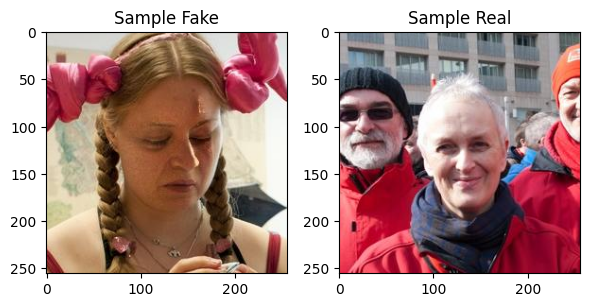

In [30]:
# Display some sample images
train_fake_dir = os.path.join(SAMPLED_DIR, "Train", "Fake")
train_real_dir = os.path.join(SAMPLED_DIR, "Train", "Real")

plt.figure(figsize=(6, 6))
plt.subplot(1,2,1)
plt.imshow(tf.keras.utils.load_img(os.path.join(train_fake_dir, os.listdir(train_fake_dir)[0])))
plt.title('Sample Fake')

plt.subplot(1,2,2)
plt.imshow(tf.keras.utils.load_img(os.path.join(train_real_dir, os.listdir(train_real_dir)[0])))
plt.title('Sample Real')

plt.tight_layout()
plt.show()

In [31]:
# Early Stopping
# class MyCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         if logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90:
#             self.model.stop_training = True

# custom_callback = MyCallback()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    mode='min',
    min_delta=0.001,
    restore_best_weights=True
)

In [32]:
# Grid Model Definition

def create_model(optimiser,lr,batch_s):
    # Grid Image Data Generators
    grid_train_data = os.path.join(GRID_SAMPLED_DIR, "Train")
    grid_validation_data = os.path.join(GRID_SAMPLED_DIR, "Validation")
    grid_test_data = os.path.join(GRID_SAMPLED_DIR, "Test")
    
    grid_train_datagen = ImageDataGenerator(rescale=1./255)
    grid_val_datagen = ImageDataGenerator(rescale=1./255)
    grid_test_datagen = ImageDataGenerator(rescale=1./255)
    
    grid_train_generator = grid_train_datagen.flow_from_directory(grid_train_data,target_size=(128, 128),batch_size=batch_s,class_mode='categorical')
    grid_val_generator = grid_val_datagen.flow_from_directory(grid_validation_data,target_size=(128, 128),batch_size=batch_s,class_mode='categorical')
    grid_test_generator = grid_test_datagen.flow_from_directory(grid_test_data, target_size=(128, 128), batch_size=batch_s,class_mode='categorical')


    grid_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        Dropout(0.20),
    
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.20),
    
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.20),
    
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        BatchNormalization(),
        Dropout(0.20),
    
        tf.keras.layers.Flatten(),
        Dropout(0.20),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    if optimiser=="adam":
        grid_model.compile(loss="binary_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
    else:
        grid_model.compile(loss="binary_crossentropy", optimizer=tf.optimizers.RMSprop(learning_rate=lr), metrics=['accuracy'])
    return grid_model,grid_train_generator,grid_val_generator

In [33]:
param_grid = {
    'optimizer': ["adam","rmsprop"],
    'batch_size': [32,64],
    'learning_rate': [0.001, 0.0001]
}
grid = ParameterGrid(param_grid)

In [34]:
def train_grid_model(params):
    grid_model,train_generator,val_generator = create_model(params['optimizer'], params['learning_rate'], params['batch_size'])
    history = grid_model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        verbose=1,
        callbacks=[early_stopping]
    )
    
    return grid_model, history

In [35]:
best_model=None
best_accuracy=0
best_params=None
val_accuracy_history={}
a=0

for params in grid:
    print(f"Training with params: {params}")
    curr_model, history = train_grid_model(params)
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validation Accuracy: {val_accuracy}\n")

    val_accuracy_history[a]=(params,history.history['val_accuracy'])
    a+=1
    
    if val_accuracy > best_accuracy:
        best_model = curr_model
        best_accuracy = val_accuracy
        best_params = params

Training with params: {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'adam'}
Found 2388 images belonging to 2 classes.
Found 2360 images belonging to 2 classes.
Found 2301 images belonging to 2 classes.
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 251ms/step - accuracy: 0.6255 - loss: 0.9731 - val_accuracy: 0.6097 - val_loss: 0.6603
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.6947 - loss: 0.6368 - val_accuracy: 0.5301 - val_loss: 0.6869
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7386 - loss: 0.5046 - val_accuracy: 0.6119 - val_loss: 0.6654
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8050 - loss: 0.4424 - val_accuracy: 0.6953 - val_loss: 0.6018
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8392 - loss: 0.3606 - val_accuracy: 0.6958 - val_loss: 0.5778
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8660 - loss: 0.3060 - val_accuracy: 0.7093 - val_loss: 0.6243
Epoch 7/20
75/75 ━━━━━━━

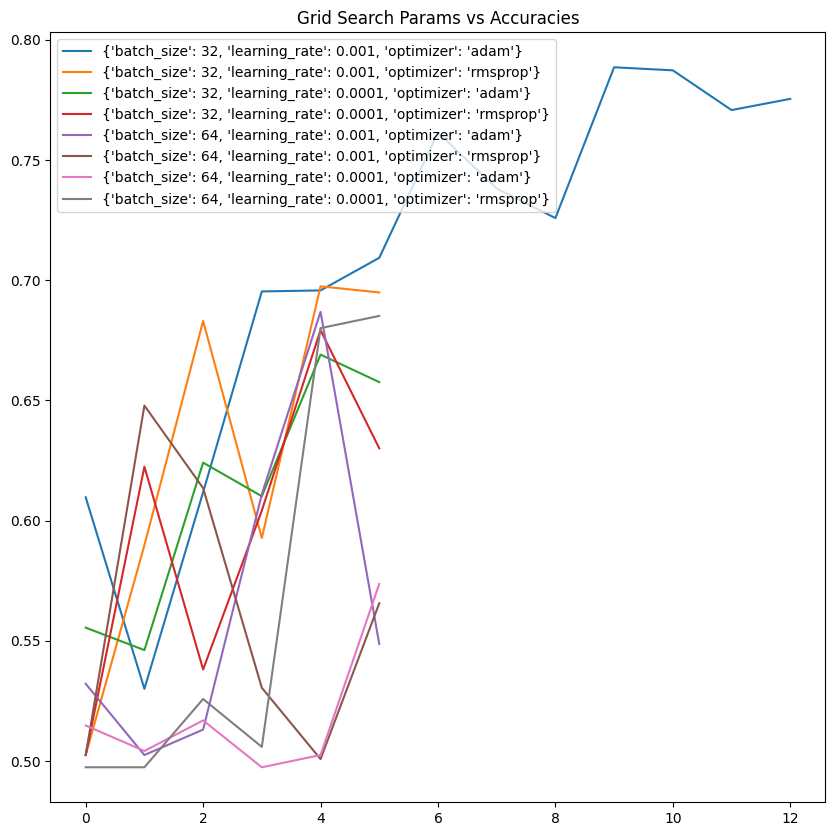

In [36]:
plt.figure(figsize=(10,10))
for i in val_accuracy_history:
    params,acc_history=val_accuracy_history[i]
    plt.plot(acc_history,label=params)
plt.title("Grid Search Params vs Accuracies")
plt.legend()
plt.show()

In [37]:
if best_model:
    print(f"Best Hyperparameters are : {best_params}")

Best Hyperparameters are : {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'adam'}


In [38]:
# Image Data Generators
best_batch_size=best_params['batch_size']
train_data = os.path.join(SAMPLED_DIR, "Train")
validation_data = os.path.join(SAMPLED_DIR, "Validation")
test_data = os.path.join(SAMPLED_DIR, "Test")

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data,target_size=(128, 128),batch_size=best_batch_size,class_mode='categorical')
val_generator = val_datagen.flow_from_directory(validation_data,target_size=(128, 128),batch_size=best_batch_size,class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data, target_size=(128, 128), batch_size=best_batch_size,class_mode='categorical')

Found 11798 images belonging to 2 classes.
Found 11132 images belonging to 2 classes.
Found 9071 images belonging to 2 classes.


In [39]:
# Model Definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    Dropout(0.20),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    BatchNormalization(),
    Dropout(0.20),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    BatchNormalization(),
    Dropout(0.20),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    BatchNormalization(),
    Dropout(0.20),

    tf.keras.layers.Flatten(),
    Dropout(0.20),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
if best_params["optimizer"]=='adam':
    model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=best_params["learning_rate"]), metrics=['accuracy'])
if best_params["optimizer"]=='rmsprop':
    model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.RMSprop(learning_rate=best_params["learning_rate"]), metrics=['accuracy'])
    

In [40]:
# Training the Model
history = model.fit(
    train_generator,
    epochs=20,
    verbose=1,
    # callbacks=[custom_callback],      ###########################
    callbacks=[early_stopping],
    validation_data=val_generator
)

# Saving Model
model.save("model.h5")

Epoch 1/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 47s 97ms/step - accuracy: 0.6831 - loss: 0.7037 - val_accuracy: 0.7229 - val_loss: 0.5471
Epoch 2/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.8084 - loss: 0.4165 - val_accuracy: 0.7966 - val_loss: 0.4444
Epoch 3/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.8723 - loss: 0.3084 - val_accuracy: 0.8463 - val_loss: 0.3551
Epoch 4/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.9043 - loss: 0.2332 - val_accuracy: 0.8396 - val_loss: 0.3948
Epoch 5/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.9324 - loss: 0.1716 - val_accuracy: 0.8697 - val_loss: 0.3335
Epoch 6/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9414 - loss: 0.1435 - val_accuracy: 0.8301 - val_loss: 0.4053
Epoch 7/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9581 - loss: 0.1116 - val_accuracy: 0.8477 - val_loss: 0.3914
Epoch 8/20
369/369 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.9613 - loss: 0.1013 - 

In [41]:
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Best Model - Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")
print(f"Best Model - Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

369/369 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9839 - loss: 0.0532
348/348 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8998 - loss: 0.2749
Best Model - Training Loss: 0.050454847514629364, Training Accuracy: 0.9845736622810364
Best Model - Validation Loss: 0.2688724994659424, Validation Accuracy: 0.9028027057647705


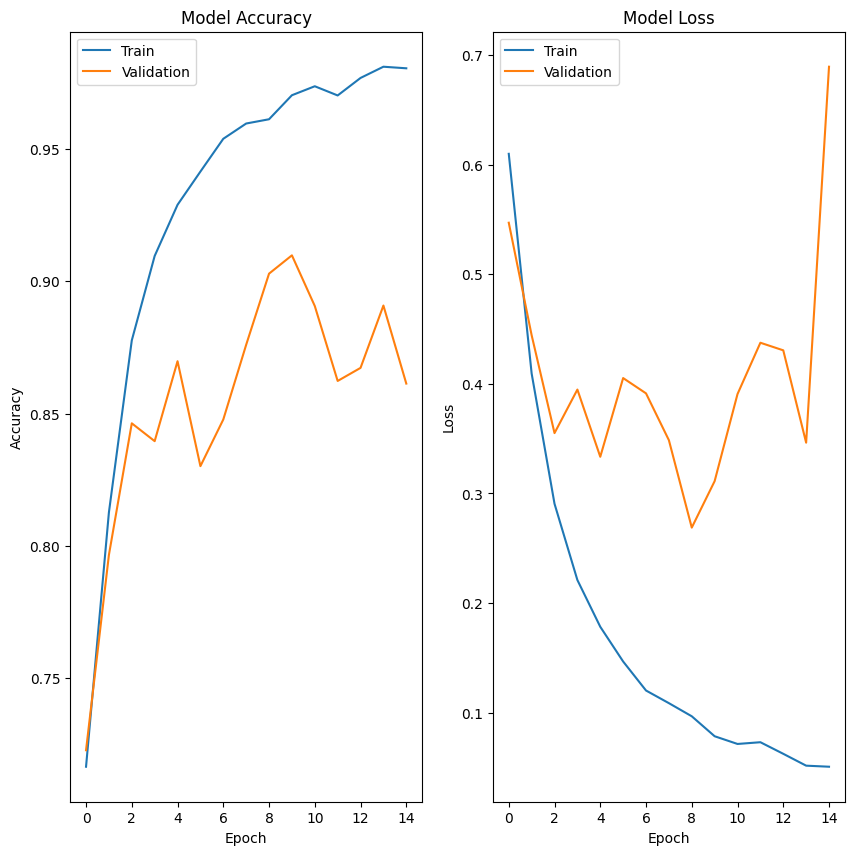

In [44]:
# Plotting Results
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history[f'val_accuracy'])
plt.title(f'Model Accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history[f'val_loss'])
plt.title(f'Model Loss')
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [43]:
# Testing Model on test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Best Model - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8411 - loss: 0.4238
Best Model - Test Loss: 0.40902402997016907, Test Accuracy: 0.8476463556289673
